# Decision trees and ensemble learning

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [76]:
df = pd.read_csv('../data/CreditScoring.csv')

df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [77]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data validation
We will map the categorical values into their real names, to facilitate the EDA. The mapping will be performed according to this [script](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R).

For example, for the 'status' column we have:

In [78]:
status_values = {1: 'ok',
                 2: 'default',
                 0: 'unk'
                }

df['status'] = df['status'].map(status_values)

Now, we repeat this to the other categorical columns:

In [79]:
home_values = {
1: 'rent',
2: 'owner',
3: 'private',
4: 'ignore',
5: 'parents',
6: 'other',
0: 'unk'
}

marital_values = {
1: 'single',
2: 'married',
3: 'widow',
4: 'separated',
5: 'divorced',
0: 'unk'
}

records_values = {
1: 'no',
2: 'yes',
0: 'unk'
}

job_values = {
1: 'fixed',
2: 'partime',
3: 'freelance',
4: 'others',
0: 'unk'
}

df['home'] = df['home'].map(home_values)
df['marital'] = df['marital'].map(marital_values)
df['records'] = df['records'].map(records_values)
df['job'] = df['job'].map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [80]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The max values of 99999999.0 in the 'income', 'assets' and 'debt' columns are suspect. In fact, this is how the missing values were dealt with in this dataset. Let's change them to 'NaN':

In [81]:
for col in ['income', 'assets', 'debt']:
    df[col].replace(to_replace={99999999.0: np.nan}, inplace=True)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Now, let's look at the target variable, 'status':

In [82]:
df['status'].value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

Only one client has the 'unknown' status, which will not be useful in this analysis; thus, the sample will be removed from the dataframe.

In [83]:
df = df[df.status != 'unk']

## Data Preparation
The data will be split into train/validation/test in a 60%/20%/20% ratio.

In [84]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [85]:
print("Size of full set: {}".format(len(df)))
print("Size of train set: {} -> {:0.1f} %".format(len(df_train), 100 * len(df_train) / len(df)))
print("Size of validation set: {} -> {:0.1f} %".format(len(df_val), 100 * len(df_val) / len(df)))
print("Size of test set: {} -> {:0.1f} %".format(len(df_test), 100 * len(df_test) / len(df)))

Size of full set: 4454
Size of train set: 2672 -> 60.0 %
Size of validation set: 891 -> 20.0 %
Size of test set: 891 -> 20.0 %


The dataset contains the NaN values inputted in the previous steps, we will substitute them with 0's.

In [86]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [87]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

Next, we will deal with the target variable, "status". We are going to change it to map "default" to 1 and "ok" to 0.

In [88]:
y_train = (df_train['status'] == "default").values
y_val = (df_val['status'] == "default").values

df_train.drop('status', axis=1, inplace=True)
df_val.drop('status', axis=1, inplace=True)

### One-Hot Encoding
Now, the categorical variables will be one-hot encoded. We will do that using DictVectorizer.

In [89]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Decision Tree Classifier
For this project, a Decision Tree Classifier will be trained to solve the problem. 

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 1.000
ROC AUC Validation = 0.661


The model is overfitting. We need to tune the tree parameters to avoid this problem.

In [91]:
from sklearn.tree import export_text

tree_text = export_text(dt, feature_names=dv.feature_names_)

print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- seniority <= 0.50
|   |   |   |   |--- class: True
|   |   |   |--- seniority >  0.50
|   |   |   |   |--- income <= 50.50
|   |   |   |   |   |--- price <= 1250.00
|   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- price >  1250.00
|   |   |   |   |   |   |--- home=private <= 0.50
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- home=private >  0.50
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |--- income >  50.50
|   |   |   |   |   |--- home=rent <= 0.50
|   |   |   |   |   |   |--- price <= 720.00
|   |   |   |   |   |   |   |--- expenses <= 52.50
|   |   |   |   |   |   |   |   |--- seniority <= 5.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- seniority >  5.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- expenses >  52.50
|   |   |   |   |  

This tree is too deep, so we will begin by limiting its maximum depth with the max_depth parameter.

In [92]:
dt = DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names=dv.feature_names_)

print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True



This tree is much shallower. Let's see how it performs:

In [93]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 0.705
ROC AUC Validation = 0.669


The model is not overfitting anymore, but the result in the validation set is still low. This is because the model is too simple.

Let's first tune the max_depth parameter:

In [94]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.752
  10 -> 0.686
  15 -> 0.658
  20 -> 0.657
None -> 0.654


The best values for the ```max_depth``` parameter are 4, 5 and 6. Now, we we will tune the ```min_samples_leaf``` parameter, that is, the minimum number of samples required to be at both left and right branches after a node splitting.

In [95]:
for m in [4, 5, 6]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))

    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.768
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.761
5 -> 0.761
10 -> 0.778
15 -> 0.785
20 -> 0.773
50 -> 0.772
100 -> 0.776
200 -> 0.768



The best parameters are ```max_depth``` = 6 and ```min_sample_leaf``` = 15. Let's use them to train the final model.

In [96]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

dt.fit(X_train, y_train)

y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 0.861
ROC AUC Validation = 0.785


### Random Forest Classifier
The best way to use decision trees is to train many of them and choose the best result based on voting, a method which is called ensemble learning. In particular, ensemble learning models using decision trees as voters are called Random Forest.

In [97]:
from sklearn.ensemble import RandomForestClassifier

aucs = []
for n in range(10, 201, 10):

    rfc = RandomForestClassifier(n_estimators=n, random_state=3)
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%3s -> %.3f' % (n, auc))

    aucs.append(auc)

 10 -> 0.781
 20 -> 0.801
 30 -> 0.813
 40 -> 0.815
 50 -> 0.816
 60 -> 0.817
 70 -> 0.818
 80 -> 0.818
 90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


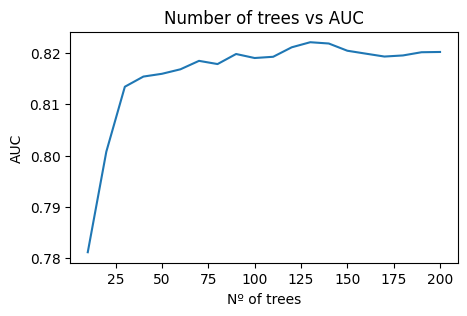

In [98]:
num_trees = range(10, 201, 10)

plt.figure(figsize=(5,3))
plt.plot(num_trees, aucs)
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs AUC')
plt.show()

We can see that after 130 trees, adding more trees is useless as the AUC stops increasing. 

Now, let's tune the parameter ```n_estimators``` along with ```max_depth```:

In [99]:
all_aucs_depth = {}

for depth in [5, 10, 20]:
    print('max_depth: %s' % depth)

    aucs = []
    for trees in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=trees, 
                                     max_depth=depth, 
                                     random_state=1)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%3s -> %.3f' % (trees, auc))

        aucs.append(auc)
    
    print()

    all_aucs_depth[depth] = aucs

max_depth: 5
 10 -> 0.788
 20 -> 0.798
 30 -> 0.800
 40 -> 0.800
 50 -> 0.800
 60 -> 0.801
 70 -> 0.802
 80 -> 0.803
 90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

max_depth: 10
 10 -> 0.791
 20 -> 0.808
 30 -> 0.812
 40 -> 0.818
 50 -> 0.817
 60 -> 0.819
 70 -> 0.820
 80 -> 0.820
 90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

max_depth: 20
 10 -> 0.776
 20 -> 0.803
 30 -> 0.813
 40 -> 0.817
 50 -> 0.815
 60 -> 0.813
 70 -> 0.814
 80 -> 0.815
 90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



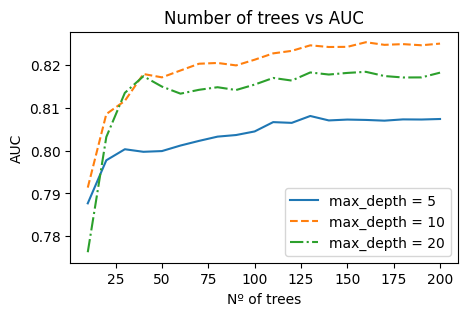

In [100]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_aucs_depth[5], '-', label='max_depth = 5')
plt.plot(num_trees, all_aucs_depth[10], '--', label='max_depth = 10')
plt.plot(num_trees, all_aucs_depth[20], '-.', label='max_depth = 20')
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

The best AUC results are with ```max_depth``` = 10. Thus, let's fix this value and tune the ```min_samples_leaf``` parameter.

In [101]:
all_aucs_leaf = {}

for samples in [3, 5, 10]:
    print('min_samples_leaf: %s' % samples)

    aucs = []
    for trees in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=trees,
                                     max_depth=10, 
                                     min_samples_leaf=samples, 
                                     random_state=1)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%3s -> %.3f' % (trees, auc))

        aucs.append(auc)
    
    print()

    all_aucs_leaf[samples] = aucs

min_samples_leaf: 3
 10 -> 0.811
 20 -> 0.820
 30 -> 0.823
 40 -> 0.822
 50 -> 0.823
 60 -> 0.823
 70 -> 0.822
 80 -> 0.823
 90 -> 0.823
100 -> 0.823
110 -> 0.823
120 -> 0.825
130 -> 0.824
140 -> 0.825
150 -> 0.825
160 -> 0.826
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

min_samples_leaf: 5
 10 -> 0.813
 20 -> 0.815
 30 -> 0.818
 40 -> 0.820
 50 -> 0.821
 60 -> 0.823
 70 -> 0.822
 80 -> 0.823
 90 -> 0.822
100 -> 0.824
110 -> 0.825
120 -> 0.825
130 -> 0.825
140 -> 0.824
150 -> 0.825
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.826
200 -> 0.825

min_samples_leaf: 10
 10 -> 0.810
 20 -> 0.818
 30 -> 0.822
 40 -> 0.822
 50 -> 0.822
 60 -> 0.822
 70 -> 0.819
 80 -> 0.820
 90 -> 0.820
100 -> 0.819
110 -> 0.820
120 -> 0.820
130 -> 0.821
140 -> 0.820
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.820
190 -> 0.820
200 -> 0.820



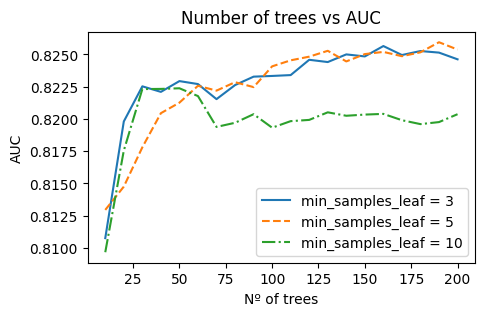

In [102]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_aucs_leaf[3], '-', label='min_samples_leaf = 3')
plt.plot(num_trees, all_aucs_leaf[5], '--', label='min_samples_leaf = 5')
plt.plot(num_trees, all_aucs_leaf[10], '-.', label='min_samples_leaf = 10')
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

The best value is ```min_samples_leaf``` = 5, and the number of estimators that yielded the best results is 200. So, we set these parameters and train our final model:

In [105]:
rfc_final = RandomForestClassifier(n_estimators=200, 
                                   max_depth=10, 
                                   min_samples_leaf=5,
                                   random_state=1)

rfc_final.fit(X_train, y_train)

y_pred_train = rfc_final.predict_proba(X_train)[:, 1]
y_pred_val = rfc_final.predict_proba(X_val)[:, 1]

rfc_score_train = roc_auc_score(y_train, y_pred_train)
rfc_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(rfc_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfc_score_val))

ROC AUC Train = 0.940
ROC AUC Validation = 0.825


Although the model overfits a little, the validation score of 0.825 is much better than our first models without parameter tuning. 

## Gradient Boosting
Finally, let's try another ensemble learning approach: gradient boosting. It consists of training models sequentially, with each subsequent model trying to correct the errors of the previous model. For this, we are going to use the XGBoost (short for "Extreme Gradient Boosting") package.

In [106]:
import xgboost as xgb